In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import astropy.io.ascii as aio
import celerite2
import celerite2.theano
from celerite2.theano import terms as theano_terms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import pymc3_ext as pmx
import scipy.stats as ss
import seaborn as sns
import theano
import theano.tensor as T

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Here are some sensible parameters for Aldebaran:

In [3]:
mu_Hz_day = 1/(24.0*3600.0)*1e6

In [4]:
A_sun = 0.2 # m/s
Laldeb = 439 # LSun
Maldeb = 1.16 # MSun
Taldeb = 3900 # K
TSun = 5800 # K

A_aldeb_scaling = Laldeb / (Maldeb**1.5*(Taldeb/TSun)**2.25)
A_aldeb = 60.0 # 170 m/s is the RMS amplitude from Farr+(2018), but who knows how many modes it contains....
A_aldeb_scaling, A_aldeb

A_real = 100.0
f_real = 1.0

In [5]:
numax_aldeb = 2.33 # muHz
Dnu_sun = 135.0 # muHz
Dnu_aldeb = (Maldeb)**0.5*(Taldeb/TSun)**3/(Laldeb)**0.75*Dnu_sun
dnu_aldeb = 0.12*Dnu_aldeb
(numax_aldeb, Dnu_aldeb, dnu_aldeb)

(2.33, 0.4609185779612971, 0.05531022935535565)

A few properties of the oscillations:

In [6]:
print('Numax period: {:.1f} d'.format(mu_Hz_day/numax_aldeb))
print('Dnu_period: {:.1f} d'.format(mu_Hz_day/Dnu_aldeb))
print('dnu_period: {:.1f} d'.format(mu_Hz_day/dnu_aldeb))

Numax period: 5.0 d
Dnu_period: 25.1 d
dnu_period: 209.3 d


We need to be careful, because there aren't all that many large spacings that can fit into the frequencies smaller than $\nu_\mathrm{max}$:

In [7]:
numax_aldeb / Dnu_aldeb

5.055122773106464

In [8]:
Nmode = 5
Amode_total = 170
fmodes = np.array([numax_aldeb - (i-Nmode//2)*Dnu_aldeb for i in range(Nmode)])
fmodes = np.sort(np.concatenate((fmodes, fmodes + dnu_aldeb)))
Amodes = np.exp(-0.5*np.square((fmodes - numax_aldeb)/Dnu_aldeb)) # Falloff with width Dnu_aldeb
Amodes = Amodes * 170 / np.sqrt(np.sum(np.square(Amodes)))
Q_true = 2*numax_aldeb / dnu_aldeb

kernel_true = np.sum([celerite2.terms.SHOTerm(sigma=A, Q=Q_true, w0=2*np.pi*f/(mu_Hz_day)) for (A, f) in zip(Amodes, fmodes)])
kernel_true = kernel_true + celerite2.terms.RealTerm(a=A_real*A_real, c=f_real/mu_Hz_day)
gp_true = celerite2.GaussianProcess(kernel_true)

We imagine that we observe once a week for a year, +/- 2 days, with uncertainty that is 2.5 +/- 0.5 m/s (comparable to Song).  For whatever reason, 25% of the measurements are dropped (bad week, whatever).

In [9]:
t_obs = np.arange(0, 365.25, 7)
t_obs = t_obs + np.random.uniform(low=-2, high=2, size=len(t_obs))
t_obs = t_obs[np.random.rand(len(t_obs)) > 0.25]

sigma_obs = 2.5 + np.random.uniform(low=-0.5, high=0.5, size=len(t_obs))

<ErrorbarContainer object of 3 artists>

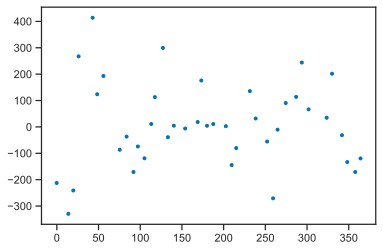

In [10]:
gp_true.compute(t_obs, yerr=sigma_obs)
rv_obs = gp_true.sample()

plt.errorbar(t_obs, rv_obs, yerr=sigma_obs, fmt='.')

Here is the true PSD:

Text(0, 0.5, '$P(f) / \\mathrm{m}^2 \\, \\mathrm{s}^{-2} \\, \\mu\\mathrm{Hz}^{-1}$')

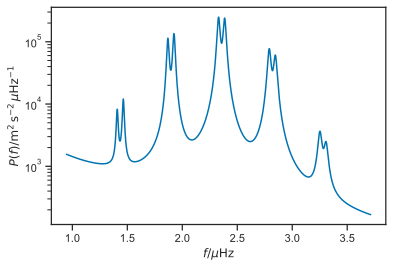

In [11]:
fs = np.linspace(numax_aldeb - (Nmode//2 + 1)*Dnu_aldeb, numax_aldeb + (Nmode//2 + 1)*Dnu_aldeb, 1024)
psd_true = gp_true.kernel.get_psd(2*np.pi*fs/mu_Hz_day)*2*np.pi/mu_Hz_day

plt.plot(fs, psd_true)
plt.yscale('log')
plt.xlabel(r'$f / \mu\mathrm{Hz}$')
plt.ylabel(r'$P(f) / \mathrm{m}^2 \, \mathrm{s}^{-2} \, \mu\mathrm{Hz}^{-1}$')

Let's build a model!

In [12]:
t_pred = np.linspace(np.min(t_obs), np.max(t_obs), 1024)
with pm.Model() as model_aldeb:
    f0 = pm.Lognormal('f0', mu=np.log(min(fmodes)), sigma=1)

    As = pm.Lognormal('As', mu=np.log(100), sigma=1, shape=(2*Nmode,))
    
    Q = pm.Lognormal('Q', mu=np.log(Q_true), sigma=1)
    
    Areal = pm.Lognormal('Areal', mu=np.log(A_real), sigma=1)
    freal = pm.Lognormal('freal', mu=np.log(f_real), sigma=1)
    
    Df = pm.Lognormal('Df', mu=np.log(Dnu_aldeb), sigma=1)
    df = pm.Lognormal('df', mu=np.log(dnu_aldeb), sigma=1)
    
    freqs1 = [f0 + i*Df for i in range(Nmode)]
    freqs2 = [f0 + i*Df + df for i in range(Nmode)]
    freqs = pm.Deterministic('freqs', T.as_tensor(freqs1+freqs2))
    terms = [theano_terms.SHOTerm(sigma=As[i], Q=Q, w0=2*np.pi*freqs[i]/mu_Hz_day) for i in range(2*Nmode)]
    
    k = theano_terms.RealTerm(a=Areal*Areal, c=freal/mu_Hz_day)
    for t in terms:
        k += t
    gp = celerite2.theano.GaussianProcess(k)
    
    gp.compute(t_obs, yerr=sigma_obs)
    gp.marginal('rv_obs', observed=rv_obs)
    
    resid = pm.Deterministic('residual', rv_obs - gp.predict(rv_obs, t=t_obs))
    psd = pm.Deterministic('PSD', gp.kernel.get_psd(2*np.pi*fs/mu_Hz_day)*2*np.pi/mu_Hz_day)
    rv_pred = pm.Deterministic('rv_pred', gp.predict(rv_obs, t=t_pred))

In [17]:
with model_aldeb:
    pbest, info = pmx.optimize(return_info=True)

optimizing logp for variables: [df, Df, freal, Areal, Q, As, f0]


message: Desired error not necessarily achieved due to precision loss.
logp: -284.8180250043878 -> -284.7409273424473


In [16]:
info

      fun: 284.8180250043878
 hess_inv: array([[ 1.00000000e+00,  0.00000000e+00,  1.18218411e+03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  2.47825409e+03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.18218411e+03,  2.47825409e+03,  1.13261523e+09,
        -3.38811591e-01,  1.71608360e+01, -2.97178747e+01,
        -1.31589862e+00, -1.08631517e+02, -3.38978735e+01,
        -1.09609968e+01, -1.22529318e+02, -1.66393073e+02,
         1.36894020e+02,  1.09973060e+02,  1.22983362e+02,
         3.35406175e+04

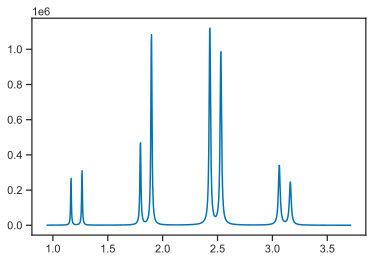

In [17]:
plt.plot(fs, pbest['PSD'])

Text(0, 0.5, '$v_r - v_{r,\\mathrm{pred}} / \\mathrm{m} \\, \\mathrm{s}^{-1}$')

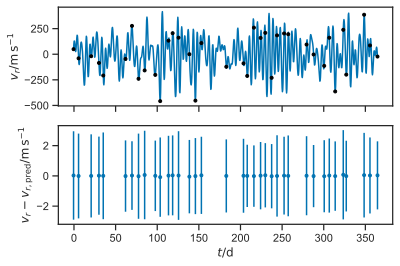

In [19]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.errorbar(t_obs, rv_obs, yerr=sigma_obs, fmt='.', color='k')
ax1.plot(t_pred, pbest['rv_pred'])
ax2.errorbar(t_obs, pbest['residual'], yerr=sigma_obs, fmt='.')
ax2.set_xlabel(r'$t / \mathrm{d}$')
ax1.set_ylabel(r'$v_r / \mathrm{m} \, \mathrm{s}^{-1}$')
ax2.set_ylabel(r'$v_r - v_{r,\mathrm{pred}} / \mathrm{m} \, \mathrm{s}^{-1}$')

In [20]:
with model_aldeb:
    trace = pmx.sample()

/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/pymc3_ext/sampling/sampling.py:97: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [df, Df, freal, Areal, Q, As, f0]


RuntimeError: Chain 1 failed.

In [20]:
pm.plot_trace(trace, var_names=['f0', 'Amax', 'fmax', 'sigma_f', 'Q', 'Areal', 'freal', 'Df', 'df'])

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/arviz/stats/density_utils.py:978: RuntimeWarning: invalid value encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f0'}>],
       [<AxesSubplot:title={'center':'Amax'}>,
        <AxesSubplot:title={'center':'Amax'}>],
       [<AxesSubplot:title={'center':'fmax'}>,
        <AxesSubplot:title={'center':'fmax'}>],
       [<AxesSubplot:title={'center':'sigma_f'}>,
        <AxesSubplot:title={'center':'sigma_f'}>],
       [<AxesSubplot:title={'center':'Q'}>,
        <AxesSubplot:title={'center':'Q'}>],
       [<AxesSubplot:title={'center':'Areal'}>,
        <AxesSubplot:title={'center':'Areal'}>],
       [<AxesSubplot:title={'center':'freal'}>,
        <AxesSubplot:title={'center':'freal'}>],
       [<AxesSubplot:title={'center':'Df'}>,
        <AxesSubplot:title={'center':'Df'}>],
       [<AxesSubplot:title={'center':'df'}>,
        <AxesSubplot:title={'center':'df'}>]], dtype=object)